# Rotinas para a detecção das não-bijetividades

In [1]:
import sys
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
sys.path.insert(0,'..')
import lib.tf_levenberg_marquardt.levenberg_marquardt as lm
import tensorflow as tf
import numpy as np
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
from tensorflow import keras
from keras import layers
from itertools import product
from time import time
from scipy.optimize import root, root_scalar

In [3]:
def load_csv2numpy(p):
    return np.loadtxt(p, delimiter=',', dtype=np.float32, skiprows=1)

In [4]:
def z2n(n):
    return n if n<0 else None

In [5]:
def prep_data_y(y, M, My=1):
    a0 = np.abs(y)
    end = z2n(-M-1)
    abs = [a0[:end],]
    for m in range(My-1):
        end = z2n(-M+m)
        abs.append(a0[m+1:end])
    abs = np.array(abs).T
    return abs

In [6]:
def prep_data(x, M):
    a0 = np.abs(x)
    end = z2n(-M-1)
    abs = [a0[:end],]
    for m in range(M):
        end = z2n(-M+m)
        abs.append(a0[m+1:end])
    abs = np.array(abs).T

    p0 = np.angle(x)
    end = z2n(-M-1)
    phase = [p0[:end],]
    for m in range(M):
        end = z2n(-M+m)
        phase.append(p0[m+1:end])
    phase = np.array(phase).T

    delta = []
    for m in range(1,M+1):
        delta.append(phase[:,m]-phase[:,m-1])
    delta = np.array(delta).T
    
    d_cos = np.cos(delta)
    d_sin = np.sin(delta)
    return abs, d_cos, d_sin

In [7]:
def recuperar_data(s, x):
    y = s*np.exp(1j*np.angle(x))
    return y

In [8]:
def gerar_s(y, x, M=0):
    s = y[M:-1]*np.exp(-1j*np.angle(x[M:-1]))
    return s.real, s.imag

In [9]:
def normalize_data(x):
    return (x)/np.std(x)

In [10]:
def gen_model(M, HL, name, activation='tanh'):
    size_input = 1+3*(M)
    inputs = keras.Input(shape=(size_input,))
    hidden = layers.Dense(HL, activation=activation)(inputs)
    output = layers.Dense(1, activation='linear')(hidden)
    model = keras.Model(inputs=inputs, outputs=output, name=name)
    model = lm.ModelWrapper(model)
    return model

In [11]:
def compile_model(model):
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        loss=lm.MeanSquaredError(),
        metrics=['accuracy','mse'])

In [12]:
def fit_model(model, epochs, inputs, s):
    history = model.fit(inputs, s, epochs=epochs, batch_size=2048, verbose=0)
    return history

In [13]:
def validation_models(model_real, model_imag, inputs, x, M):
    s_hat_real = model_real.predict(inputs, verbose=0).reshape(-1,)
    s_hat_imag = model_imag.predict(inputs, verbose=0).reshape(-1,)

    s_hat = s_hat_real + 1j*s_hat_imag
    y_hat = recuperar_data(s_hat, x[M:-1])
    # nmse
    nmse = 10*np.log10(
        np.sum(np.abs(y[M:-1]-y_hat)**2)/
        np.sum(np.abs(y[M:-1])**2)
        )
    return nmse

In [14]:
def find_best_M_HL(x, y, M_min=0, M_max=10, HL_min=1, HL_max=10):    
    best_M = 0
    best_model = None
    best_nmse = np.inf
    metaparams = product(range(M_min,M_max+1), range(HL_min,HL_max+1))
    for M, HL in metaparams:
        start = time()

        a,dc,ds = prep_data(x, M)
        inputs = np.concatenate([a,dc,ds], axis=1)
        s_real, s_imag = gerar_s(y,x,M)

        model_real = gen_model(M, HL, 'parte_real')
        model_imag = gen_model(M, HL, 'parte_imag')

        compile_model(model_real)
        compile_model(model_imag)

        fit_model(model_real, 3000, inputs, s_real)
        fit_model(model_imag, 3000, inputs, s_imag)

        nmse = validation_models(model_real, model_imag, inputs, x, M)
        end = time()
        if nmse < best_nmse:
            best_nmse = nmse
            best_model = (model_real, model_imag)
            best_M = M
            print('*** BEST ***')
            print(f'Shape:{inputs.shape[1]} M:{M} HL:{HL} nmse:{nmse} time:{end-start}')
    return best_model, best_M

In [ ]:
def run_model(x, model, M):
    a,dc,ds = prep_data(x, M)    
    inputs = np.concatenate([a,dc,ds], axis=1)
    
    s_hat_real = model[0].predict(inputs, verbose=0).reshape(-1,)
    s_hat_imag = model[1].predict(inputs, verbose=0).reshape(-1,)

    s_hat = s_hat_real + 1j*s_hat_imag
    y_hat = recuperar_data(s_hat, x[M:-1])
    return y_hat

In [34]:
def validation(model, x, y, M):
    run_model(x, model, M)
    # nmse
    nmse = 10*np.log10(
        np.sum(np.abs(y[M:-1]-y_hat)**2)/
        np.sum(np.abs(y[M:-1])**2)
        )
    print(f'Validação - nmse:{nmse}')
    #model[0].summary()
    #model[1].summary()
    return nmse, y_hat

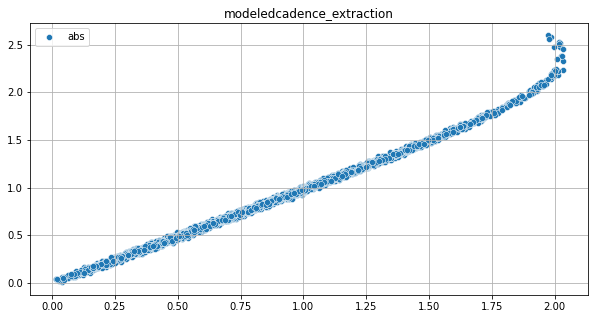

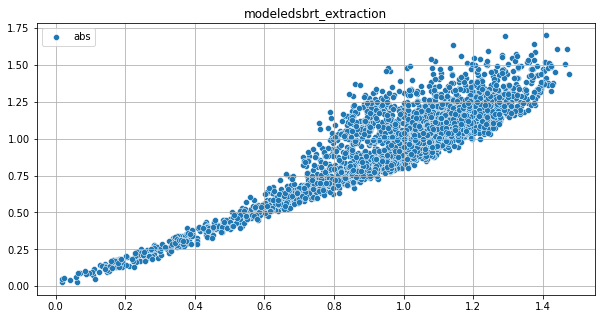

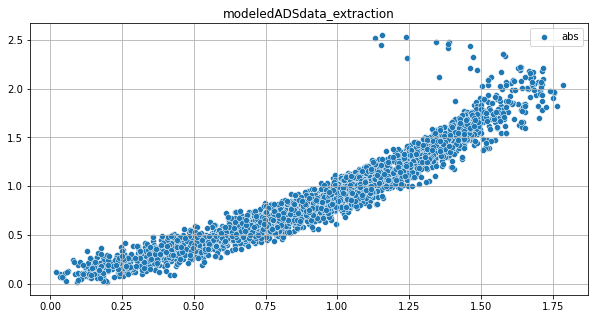

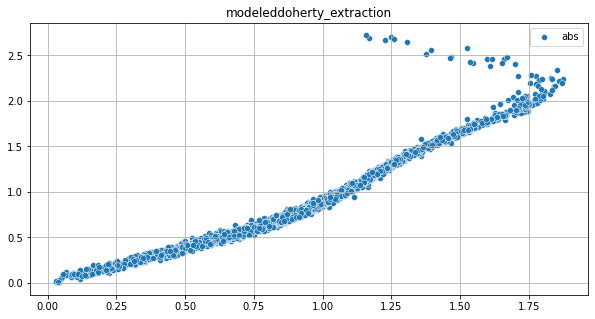

In [16]:
# plot inversa PA
for p in Path().glob('../data/*_extraction.csv'):
    data = load_csv2numpy(p)
 
    x = data[:, 2] + 1j*data[:, 3]
    x = normalize_data(x)
    x_abs = np.abs(x)

    y = data[:, 0] + 1j*data[:, 1]
    y = normalize_data(y)
    y_abs = np.abs(y)

    plt.figure(figsize=(10,5))
    sns.scatterplot(x=x_abs, y=y_abs, label='abs')
    plt.grid()
    plt.title(p.stem)
    plt.show()
    plt.close()

    # best_model, M = find_best_M_HL(x, y, M_min=3, M_max=20, HL_min=5, HL_max=20)
    '''
    pv = p.parent/p.parts[-1].replace('extraction', 'validation')
    data = load_csv2numpy(pv)

    x = data[:, 0] + 1j*data[:, 1]
    x = normalize_data(x)
    y = data[:, 2] + 1j*data[:, 3]
    y = normalize_data(y)

    nmse = validation(best_model, x, y, M)
    '''

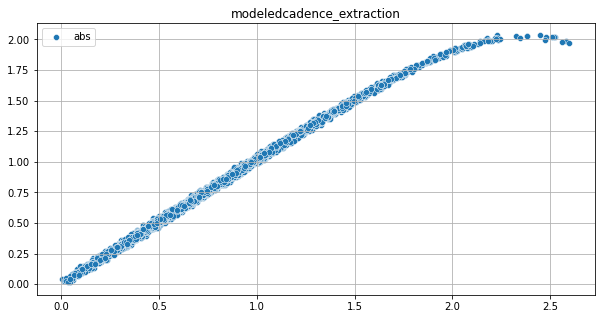

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/caio/TCC/nb/../lib/tf_levenberg_marquardt/levenberg_marquardt.py", line 722, in train_step
    self.trainer.train_step(inputs, targets)  File "/home/caio/TCC/nb/../lib/tf_levenberg_marquardt/levenberg_marquardt.py", line 585, in train_step
    loss, outputs, attempts, stop_training = self._train_step(  File "/home/caio/TCC/nb/../lib/tf_levenberg_marquardt/levenberg_marquardt.py", line 482, in _train_step
    J, JJ, rhs, outputs = init_gauss_newton(inputs, targets)  File "/home/caio/TCC/nb/../lib/tf_levenberg_marquardt/levenberg_marquardt.py", line 440, in _init_gauss_newton_overdetermined
    JJ += tf.linalg.matmul(J, J, transpose_a=True)  File "/home/caio/.pyenv/versions/3.10.4/envs/TCC/lib/python3.10/site-packages/tensorflow/python/util/

In [19]:
p = Path('../data/modeledcadence_extraction.csv')
data = load_csv2numpy(p)

x = data[:, 0] + 1j*data[:, 1]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 2] + 1j*data[:, 3]
y = normalize_data(y)
y_abs = np.abs(y)

plt.figure(figsize=(10,5))
sns.scatterplot(x=x_abs, y=y_abs, label='abs')
plt.grid()
plt.title(p.stem)
plt.show()
plt.close()

best_model, M = find_best_M_HL(x, y, M_min=3, M_max=3, HL_min=7, HL_max=7)

pv = p.parent/p.parts[-1].replace('extraction', 'validation')
data = load_csv2numpy(pv)

x = data[:, 0] + 1j*data[:, 1]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 2] + 1j*data[:, 3]
y = normalize_data(y)
y_abs = np.abs(y)

nmse = validation(best_model, x, y, M)
model = best_model


Validação - nmse:-53.554444313049316


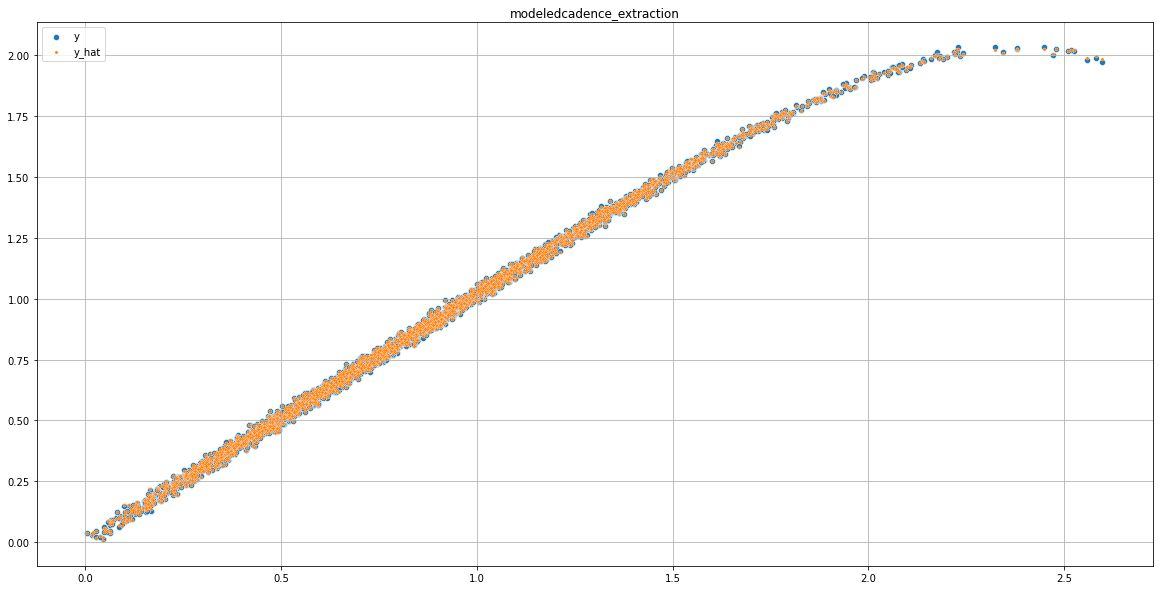

In [51]:
p = Path('../data/modeledcadence_extraction.csv')
data = load_csv2numpy(p)

x = data[:, 0] + 1j*data[:, 1]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 2] + 1j*data[:, 3]
y = normalize_data(y)
y_abs = np.abs(y)

nmse, y_hat = validation(model, x, y, M)

plt.figure(figsize=(20,10))
sns.scatterplot(x=x_abs, y=y_abs, label='y')
sns.scatterplot(x=x_abs[M:-1], y=np.abs(y_hat), label='y_hat', s=10)
plt.grid()
plt.title(p.stem)
plt.show()
plt.close()

In [53]:
from functools import partial

In [196]:
def run_model(x, model, M):
    a,dc,ds = prep_data(x, M)    
    inputs = np.concatenate([a,dc,ds], axis=1)
    
    s_hat_real = model[0].predict(inputs, verbose=0).reshape(-1,)
    s_hat_imag = model[1].predict(inputs, verbose=0).reshape(-1,)

    s_hat = s_hat_real + 1j*s_hat_imag
    y_hat = recuperar_data(s_hat, x[M:-1])
    return y_hat

In [197]:
def inverse_problem(x, y, model, M, x_old):
    x = np.array([x[0] + 1j*x[1]])    
    x = np.concatenate([x_old, x])

    y_hat = run_model(x, model, M)

    y_real, y_imag = y_hat.real, y_hat.imag
    output = np.array([y.real - y_real, y.imag - y_imag]).reshape(-1,)

    return output

In [216]:
n = 10
for n in range(30,100):
    x_old = x[n-M-1:n] # Valores de x antigos
    x0 = (2.2,2.2) # Chute inicial de x0
    
    xt = x[n-M-1:n+1] # Valores de x para extrair o y0
    y0 = run_model(xt, model, M) # Extração do y0
    
    # Problema inverso
    i_problem = partial(inverse_problem, model=model, M=M, y=y0, x_old=x_old)
    res = root(i_problem, x0=x0)
    
    # Erro
    if res.x-x0 > 0.01:
        print(n, res.x-x0, res.x, x0, res.fun)

30 [0. 0.]
31 [0. 0.]
32 [0. 0.]
33 [0. 0.]
34 [0. 0.]
35 [0. 0.]
36 [0. 0.]
37 [0. 0.]
38 [0. 0.]
39 [0. 0.]
40 [0. 0.]
41 [0. 0.]
42 [0. 0.]
43 [0. 0.]
44 [0. 0.]
45 [0. 0.]
46 [0. 0.]
47 [0. 0.]
48 [0. 0.]
49 [0. 0.]
50 [0. 0.]
51 [0. 0.]
52 [0. 0.]
53 [0. 0.]
54 [0. 0.]
55 [0. 0.]
56 [0. 0.]
57 [0. 0.]
58 [0. 0.]
59 [0. 0.]
60 [0. 0.]
61 [0. 0.]
62 [0. 0.]
63 [0. 0.]
64 [0. 0.]
65 [0. 0.]
66 [0. 0.]
67 [0. 0.]
68 [0. 0.]
69 [0. 0.]
70 [0. 0.]
71 [0. 0.]
72 [0. 0.]
73 [0. 0.]
74 [0. 0.]
75 [0. 0.]
76 [0. 0.]
77 [0. 0.]
78 [0. 0.]
79 [0. 0.]
80 [0. 0.]
81 [0. 0.]
82 [0. 0.]
83 [0. 0.]
84 [0. 0.]
85 [0. 0.]
86 [0. 0.]
87 [0. 0.]
88 [0. 0.]
89 [0. 0.]
90 [0. 0.]
91 [0. 0.]
92 [0. 0.]
93 [0. 0.]
94 [0. 0.]
95 [0. 0.]
96 [0. 0.]
97 [0. 0.]
98 [0. 0.]
99 [0. 0.]


In [219]:
res

    fjac: array([[1., 0.],
       [0., 1.]])
     fun: array([2.35405297e-07, 1.66267027e-08])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    nfev: 15
     qtf: array([2.35405297e-07, 1.66267027e-08])
       r: array([-0.,  0., -0.])
  status: 5
 success: False
       x: array([2.2, 2.2])

Num caso a saída da rede neural é a entrada
Em outro caso, a saída da rede neural é o coef*entrada
Qual a entrada instântanea que devo aplicar na rede neural
Chute inicial 0 e chute inicial 2.2 (um abaixo e outro acima da curva)
Na curva em azul, como existe mapeamento 1-1, não vai afetar
Na outra, vai afetar, para 0 pego a parte de baixo da curva 

Validação - nmse:-41.44153594970703


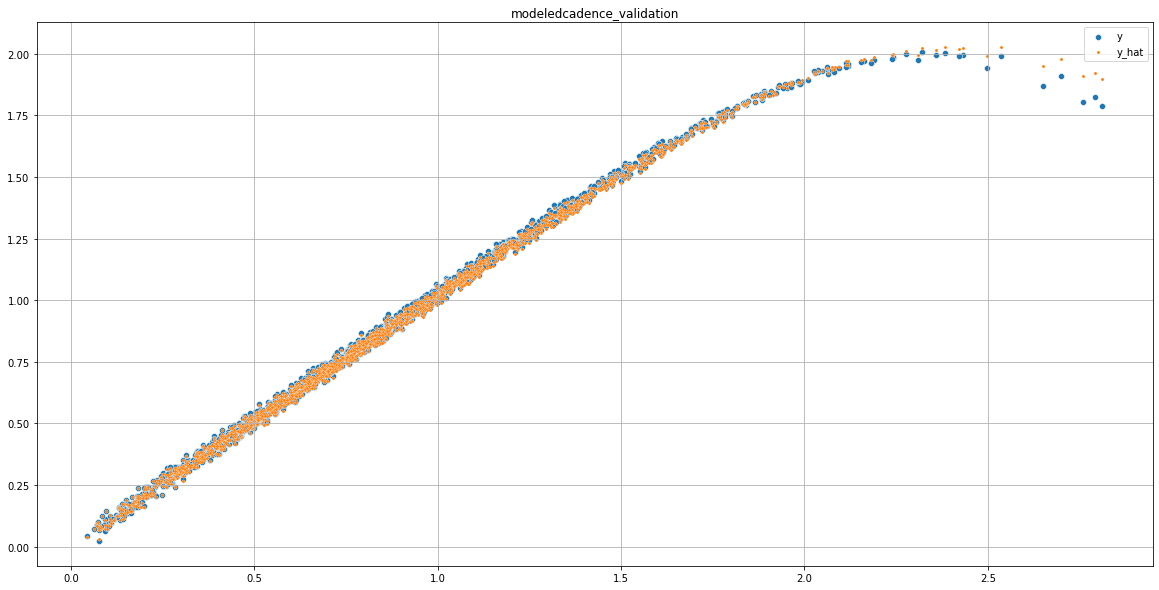

In [50]:
p = Path('../data/modeledcadence_validation.csv')
data = load_csv2numpy(p)

x = data[:, 0] + 1j*data[:, 1]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 2] + 1j*data[:, 3]
y = normalize_data(y)
y_abs = np.abs(y)

nmse, y_hat = validation(model, x, y, M)

plt.figure(figsize=(20,10))
sns.scatterplot(x=x_abs, y=y_abs, label='y')
sns.scatterplot(x=x_abs[M:-1], y=np.abs(y_hat), label='y_hat', s=10)
plt.grid()
plt.title(p.stem)
plt.show()
plt.close()